<a href="https://colab.research.google.com/github/jermwatt/machine_learning_refined/blob/main/notes/6_Linear_twoclass_classification/6_2_Cross_entropy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 6: Linear two-class classification

# Logistic Regression and the Cross Entropy Cost

In this Section we describe a fundamental framework for linear two-class classification called *logistic regression*, in particular employing the *Cross Entropy* cost function.  Logistic regression follows naturally from the regression framework regression introduced in the previous Chapter, with the added consideration that the data output is now constrained to take on *only two values*.  

In [20]:
# import standard libs
import os

# if on collab pull required subdirectories
if os.getenv("COLAB_RELEASE_TAG"): 
    # install github clone - allows for easy cloning of subdirectories
    !pip install github-clone
    from pathlib import Path 

    # clone datasets
    if not Path('chapter_6_datasets').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/6_Linear_twoclass_classification/chapter_6_datasets
    else:
        print('chapter_6_datasets already cloned!')

    # clone library subdirectory
    if not Path('chapter_6_library').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/6_Linear_twoclass_classification/chapter_6_library
    else:
        print('chapter_6_library already cloned!')

    # clone images
    if not Path('chapter_6_images').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/6_Linear_twoclass_classification/chapter_6_images
    else:
        print('chapter_6_images already cloned!')

    # clone videos
    if not Path('chapter_6_videos').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/6_Linear_twoclass_classification/chapter_6_videos
    else:
        print('chapter_6_videos already cloned!')

# append path for local library, data, and image import
import sys
sys.path.append('./chapter_6_library')
sys.path.append('./chapter_6_datasets') 
sys.path.append('./chapter_6_images') 
sys.path.append('./chapter_6_videos') 

# import section helper
import section_6_2_helpers

# dataset paths
data_path_1 = 'chapter_6_datasets/2d_classification_data_v1_entropy.csv'


# image paths
image_path_1 = 'chapter_6_images/sigmoid_step.png'
image_path_2 = 'chapter_6_images/sigmoid.png'

# video paths
video_path_1 = 'chapter_6_videos/animation_1.mp4'

# standard imports
import matplotlib.pyplot as plt
from IPython.display import Image, HTML
from base64 import b64encode

def show_video(video_path, width = 1000):
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width={width} controls><source src="{video_url}"></video>""")

# import autograd-wrapped numpy
import autograd.numpy as np

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
chapter_6_datasets already cloned!
chapter_6_library already cloned!
chapter_6_images already cloned!
Cloning into 'chapter_6_videos'...
done.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Notation and modeling

Two class classification is a particular instance of *regression* or *surface-fitting*, wherein the output of a dataset of $P$ points $\left\{ \left(\mathbf{x}_{p},y_{p}\right)\right\} _{p=1}^{P}$ is no longer continuous but takes on two fixed numbers.  The actual value of these numbers is in principle arbitrary, but particular value pairs are more helpful than others for derivation purposes (i.e., it is easier to determine a proper nonlinear function to regress on the data for particular output value pairs). Here we will use the values $y_{p}\in\left\{ 0,\,+1\right\}$ - that is every output takes on either the value $0$ or $+1$. Often in the context of classification the output values $y_p$ are called *labels*, and all points sharing the same label value are referred to as a *class* of data.  Hence a dataset containing points with label values $y_{p}\in\left\{ 0,\,+1\right\}$ is said to be a dataset consisting of two classes.

The simplest shape such a dataset can take is that of a set of linearly separated adjacent 'steps', as illustrated in the figure below. Here the 'bottom' step is the region of the space containing most of the points that have label value $y_p = 0$.  The 'top step' likewise contains most of the points having label value $y_p = +1$. These steps are largely separated by a point when $N = 1$, a line when $N = 2$, and a hyperplane when $N$ is larger (the term 'hyperplane' is also used more generally to refer to a point or line as well).  

As shown in the figure, because its output takes on a discrete set of values one can view a classification dataset 'from above', that is looking down from a point high up on the $y$ axis (or in other words, the data projected onto the plane $y = 0$).  From this perspective we remove the vertical $y$ dimension of the data and visually represent the dataset using its input only, displaying the output values of each point by coloring its input one of two unique colors (we choose blue for points with label $y_p = 0$, and red for those having label $y_p = +1$).

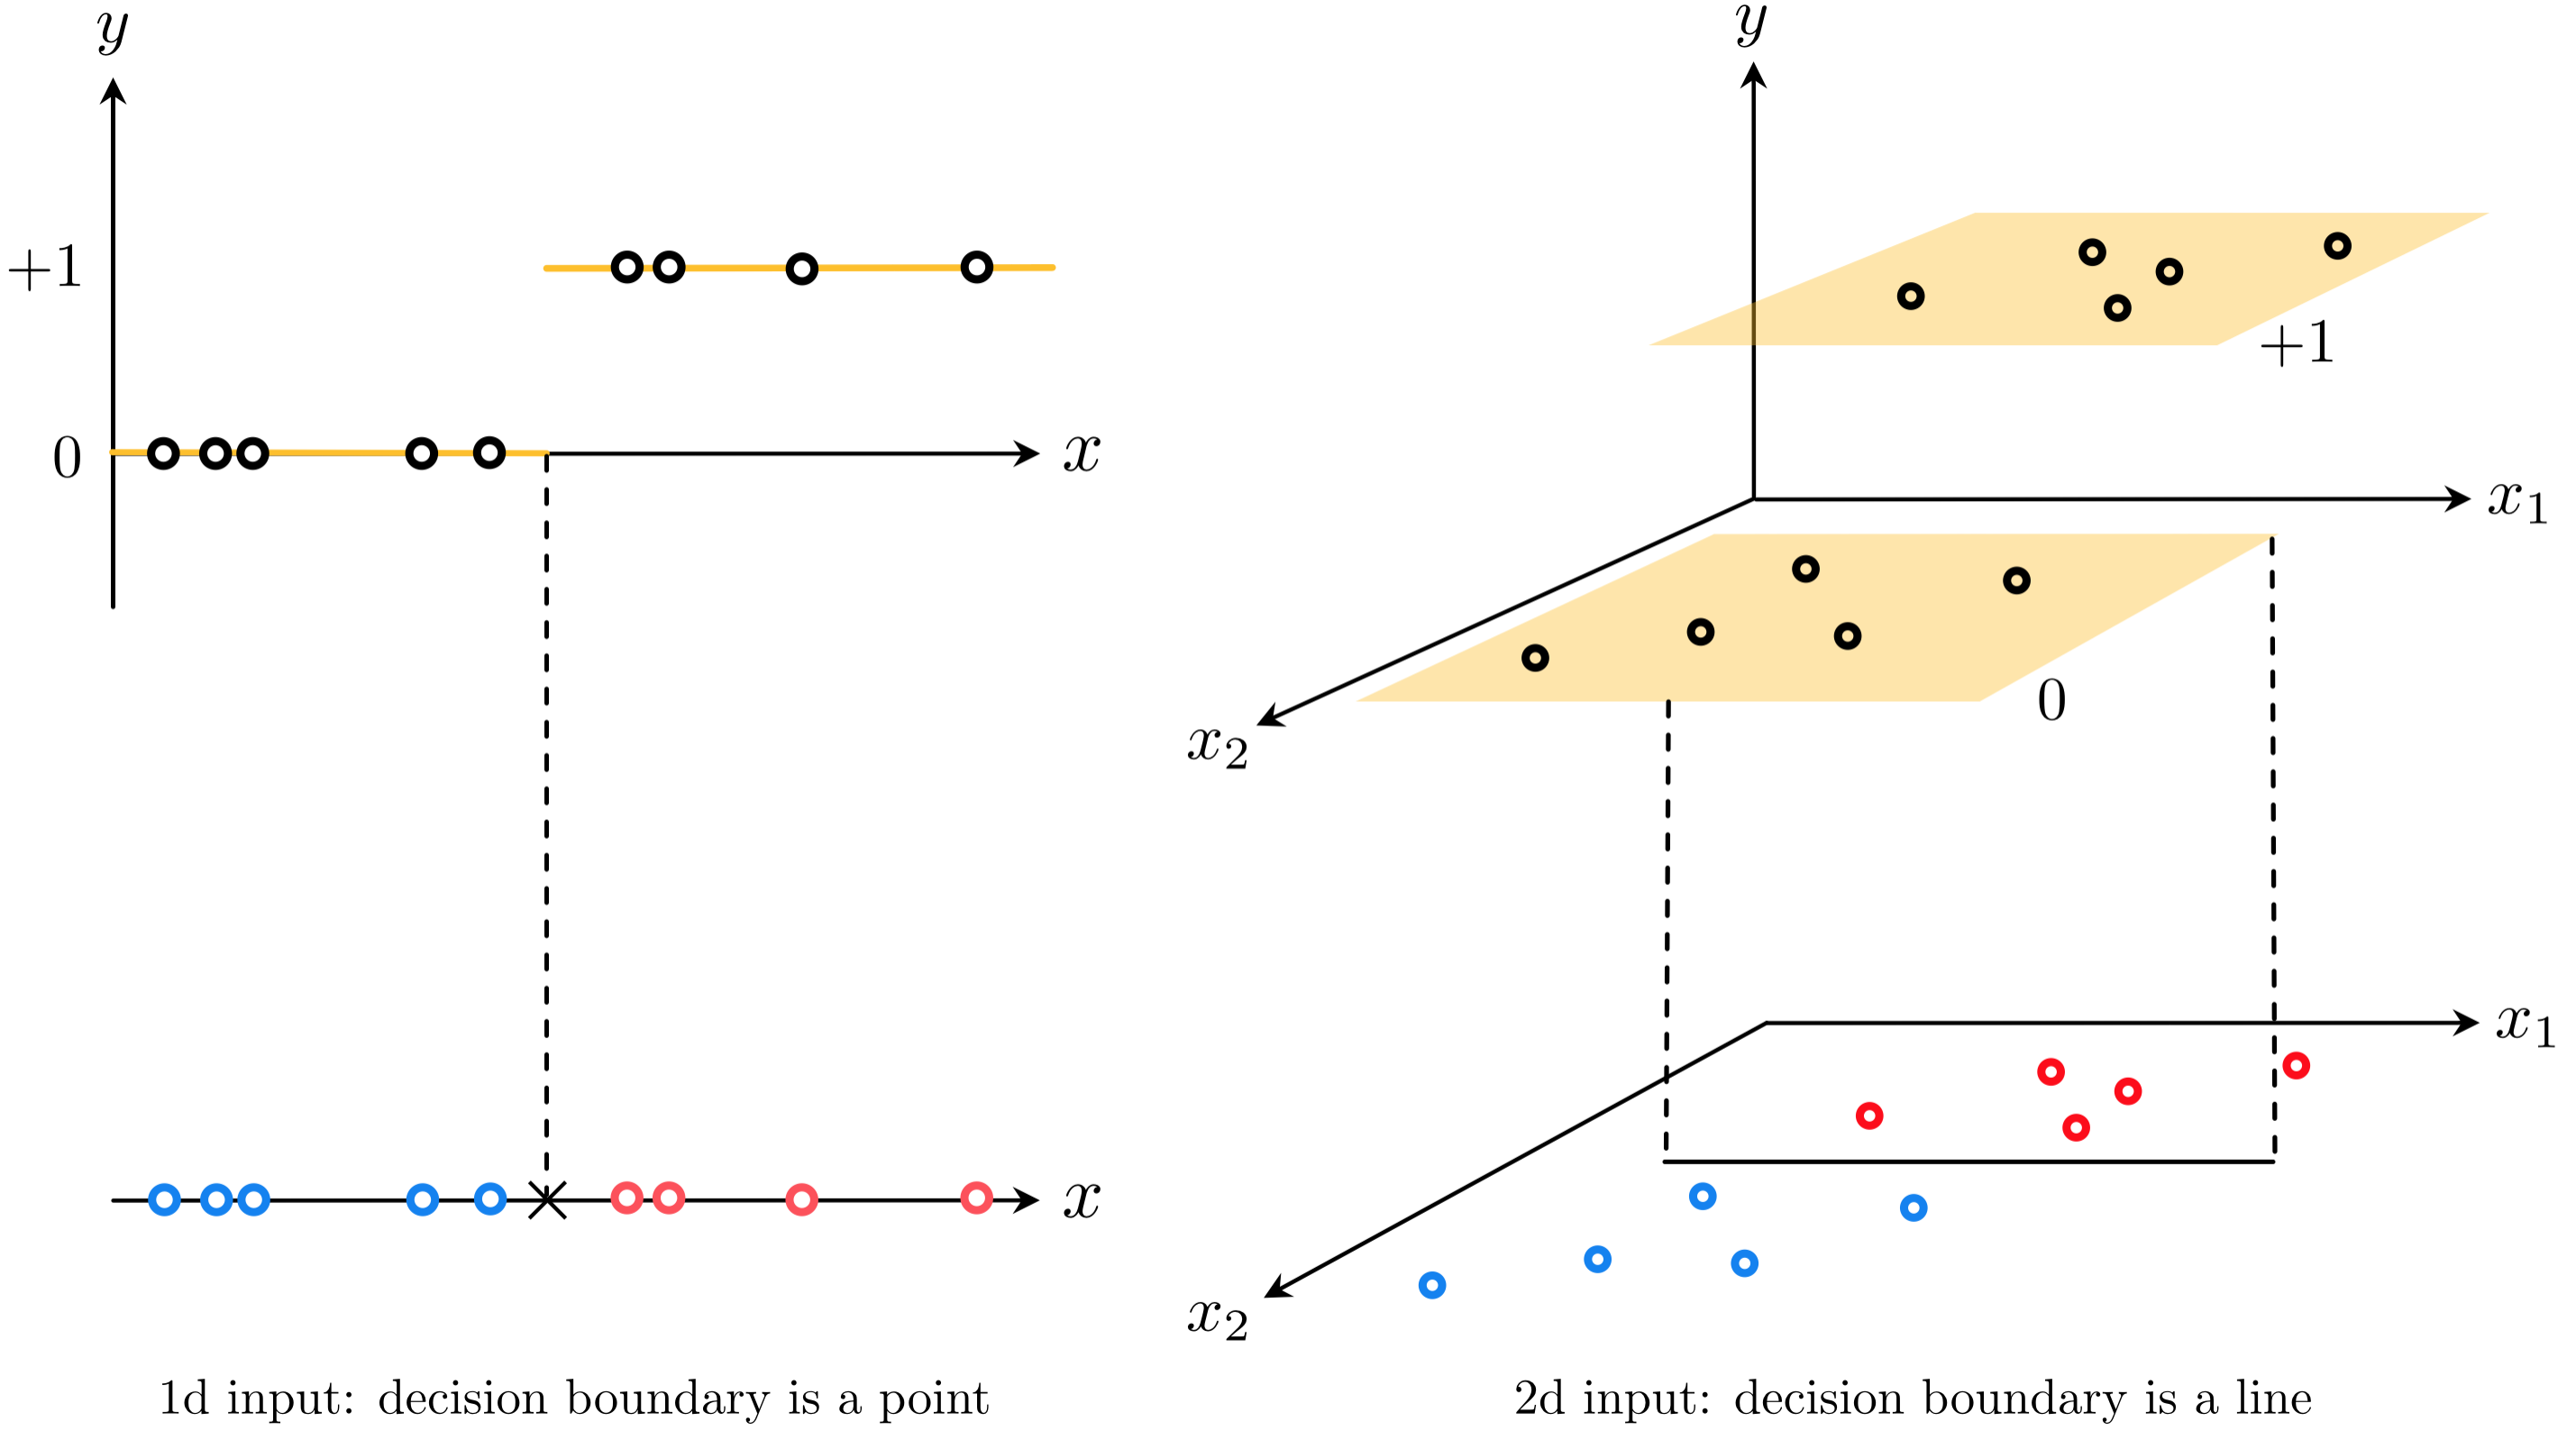

In [4]:
Image(image_path_1, width=800)

<figure>
  <figcaption>   
<strong>Figure 1:</strong> <em> Classification from a regression/surface-fitting perspective for single-input (left panels) and two-input (right panels) toy datasets. This surface-fitting view is equivalent to the perspective where we look at each respective dataset 'from above'.  In this perspective we can more easily identify the separating hyperplane, i.e., where the step function (shown here in yellow) transitions from its bottom to top step.  In this perspective the vertical axis (the actual $y$ value) is removed, with all points being represented by their input values only.  The label of each point is then represented by color: the points in blue denote label value $0$ while those in red have label $1$. </em>  </figcaption> 
</figure>

This is the simplest sort of dataset with binary output we could aim to perform regression on, as in general the boundary between the two classes of data could certainly be nonlinear. We will deal with this more general potentiality later on - when discussing neural networks, trees, and kernel-based methods - but first let us deal with the current scenario.  How can we perform regression on a dataset like the ones described in the figure above?

##   Trying to fit a discontinuous step function

How can we fit a regression to data that is largely distributed on two adjacent steps separated by a hyperplane? Lets look at a simple instance of such a dataset when $N = 1$ to build our intuition about what must be done in general.

Intuitively it is obvious that simply fitting a line of the form $y = w_0 + w_1x_{\,}$ to such a dataset will result in an extremely subpar results - the line by itself is simply too inflexible to account for the nonlinearity present in the data.  A dataset that is roughly distributed on two steps needs to be fit with a function that matches this general shape. In other words such data needs to be fit with a *step function*.

Since the boundary between the two classes is (assumed to be) linear and the labels take on values that are either $0$ or $1$, ideally we would like to fit a *discontinuous step function with a linear boundary* to such a dataset.  What does such a function look like?  When $N = 1$ a *linear model* defining this boundary is just a line $w_0 + x_{\,}w_1$ composed with the *step function* $\text{step}\left(\cdot\right)$ as

\begin{equation}
\text{step}\left(w_0 + x_{\,}w_1 \right)
\end{equation}

where the step function is defined as 

\begin{equation}
\text{step}(x) = 
\begin{cases}
1 \,\,\,\,\,\text{if} \,\, x \geq 0.5 \\
0 \,\,\,\,\,\text{if} \,\, x < 0.5 \\
\end{cases}.
\end{equation}

Note here that what happens with $\text{step}(0.5)$ is - for our purposes - arbitrary (i.e., it can be set to any fixed value or left undefined as we have done).  The linear boundary between the two steps is defined by all points $x$ where $w_0 + xw_1 = 0.5$.

More generally with general $N$ dimensional input we can write the liinear model defining the boundary employing our compact vector notation first introduced in [Section 5.2](https://jermwatt.github.io/machine_learning_refined/notes/5_Linear_regression/5_2_Least.html)

\begin{equation}
\mathbf{w}=
\begin{bmatrix}
w_{0}\\
w_{1}\\
w_{2}\\
\vdots\\
w_{N} 
\end{bmatrix}
\,\,\,\,\,\text{and}\,\,\,\,\,\,
\mathring{\mathbf{x}}_{\,}=
\begin{bmatrix}
1\\
x_{1}\\
x_{2}\\
\vdots\\
x_{N}
\end{bmatrix}.
\end{equation}

as 

\begin{equation}
\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,}  = w_{0}+ x_{1}w_{1} + x_{2}w_{2} + \cdots + x_{N}w_{N} .
\end{equation}

A corresponding step function is then simply the $\text{step}\left(\cdot\right)$ of this linear combination

\begin{equation}
\text{step}\left(\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,}\right)
\end{equation}

and the linear boundary between the steps is defined by all points $\mathring{\mathbf{x}}_{\,}$ where $\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,} = 0.5$. 

How do we tune the parameters of the line?  We could try to take the lazy way out and *first* fit the line to the classification dataset via linear regression, then compose the line with the step function to get a step function fit.  However this does not work well in general - as we will see even in the simple instance below.  Instead we need to tune the parameters $w_0$ and $w_1$ *after* composing the linear model with the step function, or in other words we need to tune the parameters of $\text{step}\left(\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,}\right)$.

#### <span style="color:#a50e3e;">Example 1: </span> Fitting a line first and taking the step afterward fails to represent a two-class dataset well

In the Python cell below we load in a simple two-class dataset (top panel), fit a line to this dataset via linear regression, and then compose the fitted line with the step function to produce a step function fit. Both the linear fit (in green) as well as its composition with the step function (in dashed red) are shown along with the data in the bottom panel.  Of course the line itself provides a terrible representation of the nonlinear dataset. But its evaluation through the step is also quite poor for such a simple dataset, failing to properly identify two points on the top step. In the parlance of classification these types of points are referred to as *misclassified points*.

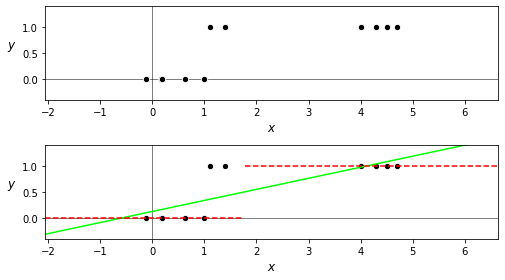

In [5]:
# load in dataset
data = np.loadtxt(data_path_1, delimiter = ',')

# create instance of linear regression demo, used below and in the next examples
demo1 = section_6_2_helpers.logistic_regression_visualizer(data)
demo1.run_algo(algo = 'newtons_method',w_init = [-1,-1], max_its = 1)

# plot dataset
demo1.naive_fitting_demo()

----

How do we tune these parameters properly? As with linear regression, here we can try to setup a proper Least Squares function that - when minimized - recovers our ideal weights. We can do this by simply reflecting on the sort of ideal relationship we want to find between the input and output of our dataset. 

Take a single point $\left(\mathbf{x}_p,\,y_p \right)$. Notice in the example above - and this is true more generally speaking - that ideally for a good fit we would like our weights to be such if this point has a label $+1$ it lies in the positive region of the space where $\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,} > 0.5$ so that $\text{step}\left(\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,}\right) = +1$ matches its label value.  Likewise if this point has label $0$ we would like it to lie in the negative region where $\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,}< 0.5$ so that $\text{step}\left(\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,}\right) = 0$ matches its label value. So in short what we would ideally like for this point is that its evaluation matches its label value, i.e., that

\begin{equation}
\text{step}\left(\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,}\right)= y_p^{\,}.
\end{equation}

And of course we would like this to hold for every point.  To find weights that satisfy this set of $P$ equalities as best as possible we could - as we did previously with linear regression - square the difference between both sides of each and average them, giving the Least Squares function

\begin{equation}
g(\mathbf{w}) = \frac{1}{P}\sum_{p=1}^P \left(\text{step}\left(\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,}\right)  - y_p \right)^2
\end{equation}

which we can try to minimize in order to recover weights that satisfy our desired equalities. If we can find a set of weights such that $g(\mathbf{w}) = 0$ then all $P$ equalities above hold true, otherwise some of them do not. 

Unfortunately because this Least Squares cost takes on only integer values it is impossible to minimize with our gradient-based techniques, as at every point the function is completely flat, i.e., it has exactly zero gradient. Because of this neither gradient descent nor Newton's method can take a single step 'downhill' regardless of where they are initialized. This problem is inherited from our use of the step function, itself a discontinuous step.

#### <span style="color:#a50e3e;">Example 2: </span> Visualizing various cost functions on a toy dataset

In the next Python cell we plot the Least Squares in equation (4) (left panel) for the dataset displayed in Example 1, over a wide range of values for $w_0$ and $w_1$.  This Least Squares surface consists of discrete steps at many different levels, each one completely flat.  Because of this no local method can be used to minimize the counting cost.

In the middle and right panels we plot the surfaces of two related cost functions on the same dataset.  We introduce the cost function shown in the middle panel in the next subection, and the cost in the right panel in the one that follows.  We can indeed minimize either of these using a local method to recover ideal weights.

/usr/local/lib/python3.9/dist-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/content/./chapter_6_library/section_6_2_helpers.py:1126: RuntimeWarning: invalid value encountered in double_scalars
  cost -= (y_p*np.log(a_p) + (1-y_p)*np.log(1 - a_p))


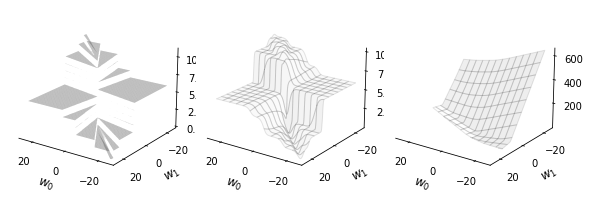

In [6]:
# create an instance of the visualizer and plot
demo2 = section_6_2_helpers.cost_visualizer(data)
demo2.plot_costs(viewmax = 25,view = [20,125])

##  The logistic sigmoid function

As mentioned above, we cannot directly minimize the Least Squares above due to our use of the step function. In other words, we cannot directly fit a *discontinuous* step function to our data. In order to go further we need to replace the step function, ideally with a *continuous* function that matches it very closely everywhere. Thankfully such a function is readily available: the sigmoid function, $\sigma(\cdot)$

\begin{equation}
\sigma\left(x\right) = \frac{1}{1 + e^{-x}}.
\end{equation}

This kind of function is alternatively called a *logistic* function - and when we fit such a function to a classification dataset we are therefore performing regression with a logistic or *logistic regression*.

In the figure below we plot the sigmoid function (left panel), as well as several internally weighted versions of it (right panel). As we can see in the figure, for the correct setting of internal weights the hyperbolic tangent function can be made to look arbitrarily similar to the step function.

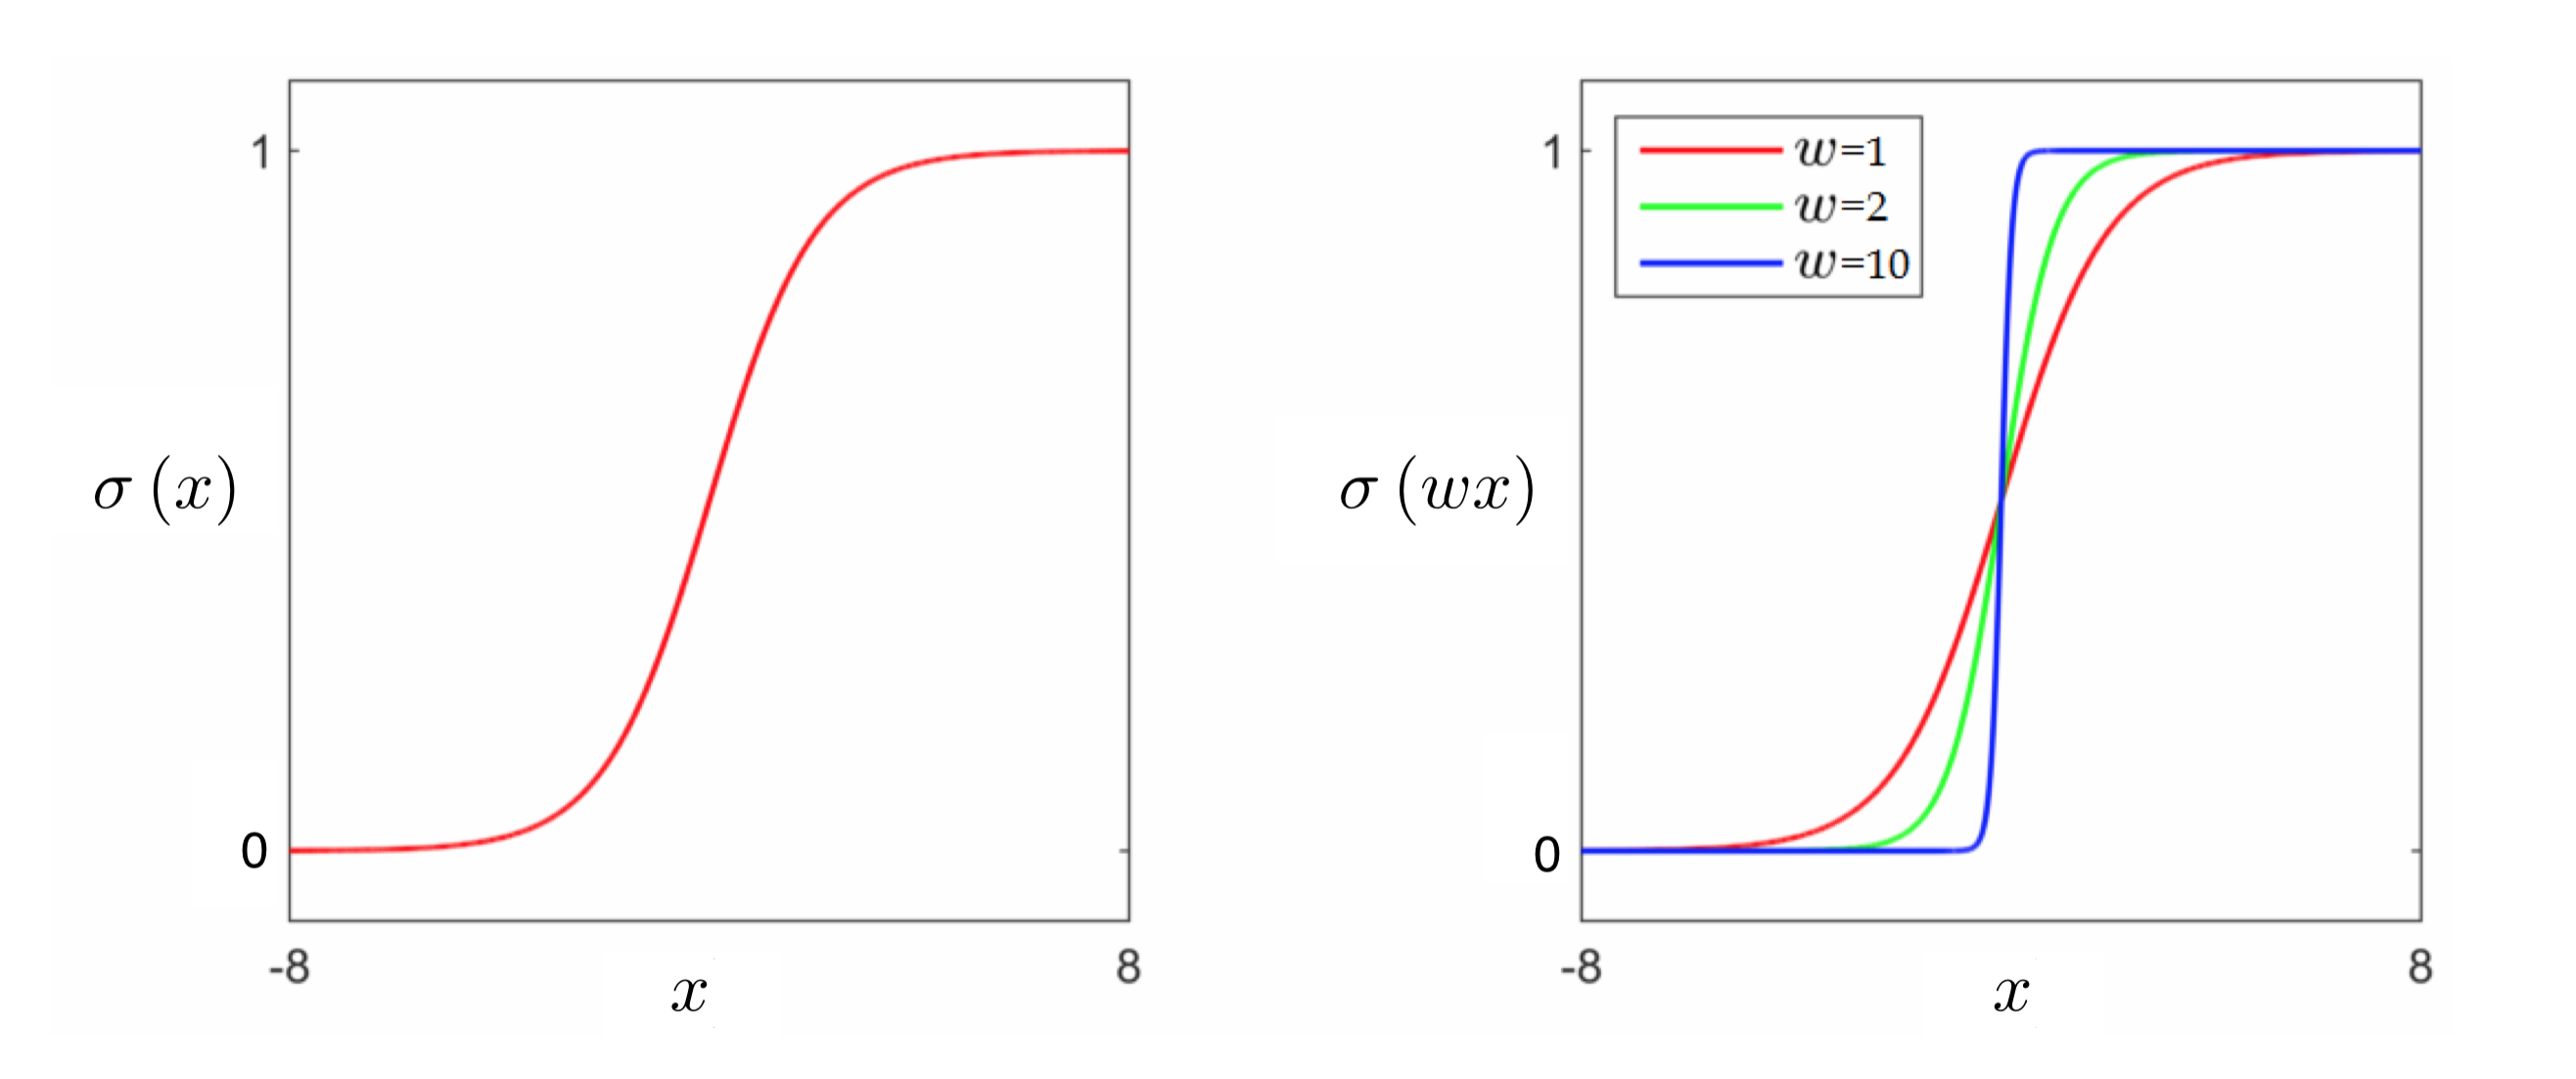

In [9]:
Image(image_path_2, width=800)

<figure>
    <figcaption>   
<strong>Figure 2:</strong> <em> (left panel) Plot of the sigmoid function $\text{tanh}(x)$. (right panel) By increasing the weight $w$ in $\sigma(wx)$ from $w=1$ (shown in red) to $w=2$ (shown in green) and finally to $w=10$ (shown in blue), the internally weighted version of the sigmoid function becomes an increasingly
good approximator of the step function. </em>  </figcaption> 
</figure>

## Logistic regression using the Least Squares cost

Swapping out the step function with sigmoid in equation (5) we aim to satisfy as many of the $P$ equations

\begin{equation}
\sigma\left(\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,}\right) = y_p \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p=1,..,P
\end{equation}

as possible.  To *learn* parameters that force these approximations to hold we can do precisely what we did in the case of linear regression: try to minimize the e.g., the squared error between both sides constructing the Least Squares point-wise cost

\begin{equation}
g_p\left(\mathbf{w}\right) = \left(\sigma\left(\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,}\right) - y_p \right)^2 \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p=1,..,P.
\end{equation}

Taking the average of these squared errors gives a Least Squares cost for *logistic regression*

\begin{equation}
g\left(\mathbf{w}\right) = \frac{1}{P}\sum_{p=1}^P \left(\sigma\left(\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,} \right) - y_p \right)^2
\end{equation}

This function - an example of which is plotted in the previous example - is generally non-convex and contains large flat regions.  Because of this - as we saw in Chapters 3 and 4 - this sort of function is not easily minimized using stanard gradient descent or Newtons method algorithms.  Specialized algorithms - like the normalized gradient descent scheme presented in [Section 3.9](https://jermwatt.github.io/machine_learning_refined/notes/3_First_order_methods/3_9_Normalized.html) - can be employed successfully as we show in the example below.   However it is more commonplace to simply employ a different and *convex* cost function based on the set of desired approximations in equation (4).  We do this following the example.

#### <span style="color:#a50e3e;">Example 3. </span>  Normalized gradient descent for Least Squares logistic regression 

In this example we show how normalized gradient descent can be used to minimize the logistic Least Squares cost, translated into Python in the next cell.

In [10]:
# define sigmoid function
def sigmoid(t):
    return 1/(1 + np.exp(-t))

# sigmoid non-convex logistic least squares cost function
def sigmoid_least_squares(w):
    cost = 0
    for p in range(y.size):
        x_p = x[:,p]
        y_p = y[:,p]
        cost += (sigmoid(w[0] + w[1]*x_p) - y_p)**2
    return cost/y.size

First, we load in a simulated one-dimensional dataset (left panel) and plot its corresponding tanh Least Squares cost (right panel).

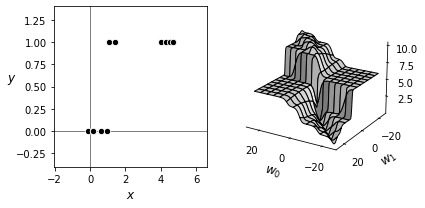

In [11]:
data = np.loadtxt(data_path_1, delimiter = ',')

# create an instance of the visualizer and plot
demo = section_6_2_helpers.LS_visualizer(data)
demo.plot_costs(viewmax = 25, view = [21,121])

We now run normalized gradient descent for $900$ iterations, initialized at $w_0=-w_1=20$, with steplength parameter fixed at $\alpha=1$.  

In [12]:
# get input/output pairs
x = data[:-1,:]
y = data[-1:,:] 

# run normalized gradient descent
w = np.asarray([20.0,-20.0])[:,np.newaxis]
w_hist = section_6_2_helpers.normalized_gradient_descent(g = sigmoid_least_squares,w = w,max_its = 900, alpha = 1)

The cell below plots the Least Squares logistic regression fit to the data (left panel) along with the gradient descent  path towards the minimum on the contour plot of the cost function (right panel). The normalized gradient descent steps are colored green to red as the run progresses.  

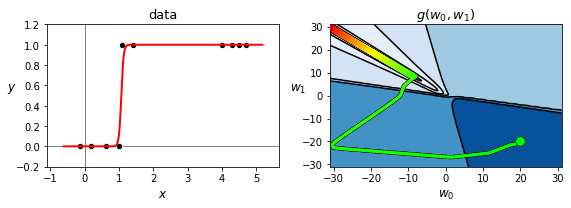

In [13]:
# create instance of logisic regression demo and load in data, cost function, and descent history
demo2 = section_6_2_helpers.entropy_visualizer(data,sigmoid_least_squares)

# create a static figure illustrating gradient descent steps 
demo2.static_fig(w_hist,num_contours = 25,viewmax = 31)

##  Logistic regression using the Cross Entropy cost

There is more than one way to form a cost function whose minimum forces as many of the $P$ equalities in equation (4) to hold as possible.  The squared error / point-wise cost $g_p\left(\mathbf{w}\right) = \left(\sigma\left(\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,} \right) - y_p\right)^2$ penalty works universally, regardless of the values taken by the output by $y_p$.  However because we *know* that the output we deal with now is limited to the *discrete* values $y_p \in \left\{0,1\right\}$ it is reasonable to ask if we cannot create a more appropriate cost that is customized to deal with just such output.

Such a point-wise cost does exist for these restricted output values.  One such cost - which we call the *Log Error* - is as follows

\begin{equation}
g_p\left(\mathbf{w}\right)=
\begin{cases}
-\text{log}\left(\sigma\left( \mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,} \right) \right) \,\,\,\,\,\,\,\,\,\,  \,\,\,\,  \text{if} \,\, y_p = 1 \\
-\text{log}\left(1 - \sigma\left( \mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,} \right) \right) \,\,\,\,\,\text{if} \,\, y_p = 0. \\
\end{cases}
\end{equation}

First notice that *regardless of the weight values* this point-wise cost is *always nonnegative* and takes on a minimum value at $0$.  Second notice how this penalizes violations of our desired equalities in equation (4) (and much more harshly than a Least Squares cost too).  A plot showing both the Least Squares and Log Error point-wise costs are shown below.

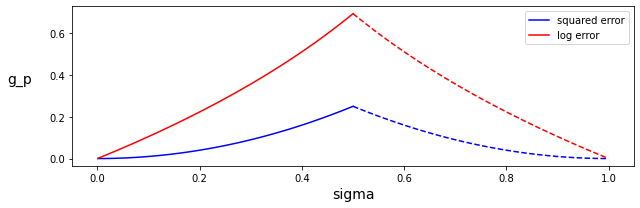

In [14]:
# setup figure
fig = plt.figure(figsize = (9,3))

# plot the per point cost when label = 1  
y = 1
alpha = np.linspace(0.5,.999,100)

least_squares = (y-alpha)**2
plt.plot(alpha, least_squares, 'b--')

log_error = -np.log(alpha)
plt.plot(alpha, log_error, 'r--')

# plot the per point cost when label = 0
y = 0
alpha = np.linspace(0.001,.5,100)

least_squares = (y-alpha)**2
plt.plot(alpha, least_squares, color='b', label='squared error')

log_error = -np.log(1-alpha)
plt.plot(alpha, log_error, color='r', label='log error')

# plot
plt.legend()
plt.xlabel('sigma',fontsize=14)
plt.ylabel('g_p', fontsize=14, rotation=0, labelpad=30)
plt.show()


Suppose we have our *optimally tuned our weights* and that $y_p = 1$.  Then with our ideal weights we should satisfy our desired equality and have $\sigma\left(\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,}\right)  \approx y_p = 1$, and if this indeed the case then $-\text{log}\left(\sigma\left(\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,}\right) \right) \approx  -\text{log}\left(1\right) = 0$ which is a neglibable penalty.  However if $\sigma\left(\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,}\right)  < 1$ the value $-\text{log}\left(\sigma\left(\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,}\right) \right)$ *becomes large and positive very quickly harshly penalizing violations of our desired equality*.   As $\sigma\left(\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,}\right) $ approaches $0$ - the worst possible value it could take on if indeed $y_p = 1$ - then cost value goes to *positive infinity*.  So indeed, this point-wise cost function penalizes violations when $y_p = 1$ very strictly and is minimal (equals $0$) in value when the desired equality holds.  Precisely the same thing can be said when $y_p = 0$, that this point-wise cost takes on a minimal value when $\sigma\left(\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,}\right)  \approx 0$ and is very large otherwise going to positive infinity as $\sigma\left(\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,}\right) $ approaches the worst possible value of $1$.  

So - in short - point-wise cost severely punishes violations of our desired equalitiesa and takes on a minimum value of $0$ when our weights $\mathbf{w}$ are properly tuned i.e.,

\begin{equation}
g_p\left(\mathbf{w}\right)\approx 0.
\end{equation}

We can then form the so-called *Cross Entropy* cost function by taking the average of the Log Error costs over all $P$ points as

\begin{equation}
g\left(\mathbf{w}\right) = \frac{1}{P}\sum_{p=1}^P g_p\left(\mathbf{w}\right). 
\end{equation}

Finally notice that we can write the Log Error equivalently - combining the two cases -  in a single line as

\begin{equation}
g_p\left(\mathbf{w}\right)=
-y_p\,\text{log}\left(\sigma\left(\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,}\right) \right) 
-\left(1-y_p\right)\text{log}\left(1 -\sigma\left(\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,}\right) \right).
\end{equation}

We can form the same cost function as above by taking the average of this form of the Log Error giving

\begin{equation}
g\left(\mathbf{w}\right) = \frac{1}{P}\sum_{p=1}^P g_p\left(\mathbf{w}\right) = - \frac{1}{P}\sum_{p=1}^P y_p\,\text{log}\left(\sigma\left(\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,}\right) \right) 
+\left(1-y_p\right)\text{log}\left(1 - \sigma\left(\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,}\right) \right)
\end{equation}

which is the more common way of expressing the Cross Entropy cost.

In any case, to recover the *ideal* weights that make the formulae in equation (4) hold as tightly as possible we want to *minimize* this cost over $\mathbf{w}$.   In other words, to optimally tune the parameters $\mathbf{w}$ we want to *minimize* the Cross Entropy cost as 

\begin{equation}
\underset{\mathbf{w}}{\mbox{minimize}}\,\, -\frac{1}{P}\sum_{p=1}^P  y_p\,\text{log}\left(\sigma\left(\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,}\right)\right) + \left(1 - y_p\right)\text{log}\left(1 - \sigma\left(\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,}\right)\right) 
\end{equation}

since the smaller this cost function becomes the better we have tuned our parameters $\mathbf{w}$.

The Cross Entropy cost is *always convex* regardless of the dataset used - we will see this empirically in the examples below and a mathematical proof is provided in the appendix of this Section that verifies this claim more generally. We displayed a particular instance of the cost surface in the right panel of Example 2 for the dataset first shown in Example 1. Looking back at this surface plot we can see that it is indeed convex.

Since the Cross Entropy cost function is convex a variety of local optimization schemes can be more easily used to properly minimize it.  For this reason the Cross Entropy cost is used more often in practice for logistic regression than is the logistic Least Squares cost.

## Implementing and minimizing a modular Cross Entropy cost in `Python`

We can implement the Cross Entropy costs very similarly to the way we did the Least Sqwuares cost for linear regression, as detailed in [Section 5.2](https://jermwatt.github.io/machine_learning_refined/notes/5_Linear_regression/5_2_Least.html), breaking down our implementation into the linear `model` and the error itself.  Our linear `model` takes in both an appended input point $\mathring{\mathbf{x}}_p$ and a set of weights $\mathbf{w}$ 

\begin{equation}
\text{model}\left(\mathbf{x}_p,\mathbf{w}\right) = \mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,}.
\end{equation}

With this notation for our model, the corresponding Cross Entropy cost in equation (16) can be written

\begin{equation*}
g(\mathbf{w}) = -\frac{1}{P}\sum_{p=1}^P  y_p\text{log}\left(\sigma\left(\text{model}\left(\mathbf{x}_p,\mathbf{w}\right)\right)\right) + \left(1 - y_p\right)\text{log}\left(1 - \sigma\left(\text{model}\left(\mathbf{x}_p,\mathbf{w}\right)\right)\right) 
\end{equation*}

We can then implement the cost in chunks - first the `model` function below precisely as we did with linear regression.

In [15]:
# compute linear combination of input point
def model(x,w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

We can then implement the Cross Entropy cost function by e.g., implementing the Log Loss error and employing efficient and compact `numpy` operations as

In [16]:
# define sigmoid function
def sigmoid(t):
    return 1/(1 + np.exp(-t))

# the convex cross-entropy cost function
def cross_entropy(w):
    # compute sigmoid of model
    a = sigmoid(model(x,w))
    
    # compute cost of label 0 points
    ind = np.argwhere(y == 0)[:,1]
    cost = -np.sum(np.log(1 - a[:,ind]))
    
    # add cost on label 1 points
    ind = np.argwhere(y==1)[:,1]
    cost -= np.sum(np.log(a[:,ind]))
    
    # compute cross-entropy
    return cost/y.size

To minimize this cost we can use virtually any local optimization method detailed in Chapters 2 - 4.  For first and second order methods (e.g., standard gradient descent and Newton's method schemes) an Automatic Differentiator can be used - e.g., employing `autograd` as detailed in [Section 3.5](https://jermwatt.github.io/machine_learning_refined/notes/3_First_order_methods/3_5_Automatic.html) - to properly compute its gradient and Hessian.

Alternatively one can indeed compute the gradient and Hessian of the Cross Entropy cost in closed form, and implement them directly.  Using the simple derivative rules outlined in the Appendix of this text the gradient can be computed as 

\begin{equation}
\nabla g\left(\mathbf{w}\right) = - \frac{1}{P}\sum_{p = 1}^P\left(y_p - \sigma\left(\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,}\right)\right) \mathring{\mathbf{x}}_{p}
\end{equation}

In addition to employ Newton's method 'by hand' one can hand compute the Hessian of the Cross Entropy function as



\begin{equation}
\nabla^2 g\left(\mathbf{w}\right) =  \frac{1}{P}\sum_{p = 1}^P  \sigma\left(\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,}\right)\left(1 -  \sigma\left(\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,}\right)\right) \mathring{\mathbf{x}}_p^{\,}\mathring{\mathbf{x}}_p^T.
\end{equation}

#### <span style="color:#a50e3e;">Example 3: </span> Using gradient descent to perform logistic regression using the Cross Entropy cost

In this example we repeat the experiments of Example 2 using the Cross Entropy cost and gradient descent. 

With our cost function defined in ``Python`` we can now run our demonstration. We initialize at the point $w_0 = 3$ and $w_1 =3$, set $\alpha = 1$, and run for 25 steps.  

In [17]:
# take input/output pairs from data
x = data[:-1,:]
y = data[-1:,:] 

# run gradient descent to minimize the softmax cost
g = cross_entropy; w = np.array([3.0,3.0])[:,np.newaxis]; max_its = 100; alpha_choice = 10**(0);
weight_history,cost_history = section_6_2_helpers.gradient_descent(g,alpha_choice,max_its,w)

Each step of the run is now animated - along with its corresponding fit to the data.  In the left panel both the data and the fit at each step (colored green to red as the run continues) are shown, while in the right panel the contour of the cost function is shown with each step marked (again colored green to red as the run continues).  Moving the slider from left to right animates the run from start to finish. Note how we still have some zig-zagging behavior here, but since we can safely use unnormalized gradient descent, its oscillations rapidly decrease in magnitude since the length of each step is directly controlled by the magnitude of the gradient.

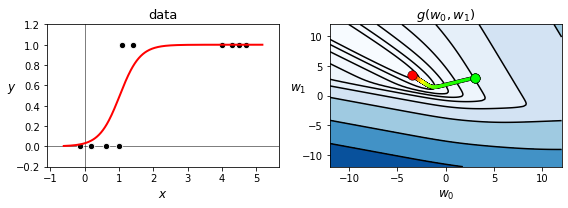

In [21]:
# create instance of logisic regression demo and load in data, cost function, and descent history
animator = section_6_2_helpers.entropy_visualizer(data,cross_entropy)

# animate descent process
animator.animate_run(video_path_1,weight_history,num_contours = 25,viewmax = 12,fps=15)

In [22]:
show_video(video_path_1)

Below we show the result of running gradient descent with the same initial point and fixed steplength parameter for $2000$ iterations, which results in a better fit.

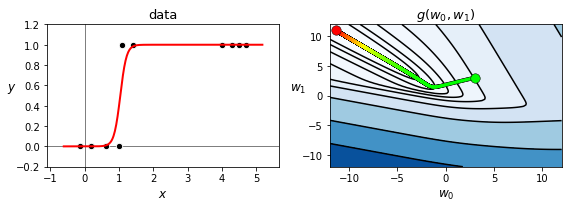

In [23]:
# run gradient descent to minimize the softmax cost
g = cross_entropy; w = np.array([3.0,3.0])[:,np.newaxis]; max_its = 2000; alpha_choice = 1;
weight_history,cost_history = section_6_2_helpers.gradient_descent(g,alpha_choice,max_its,w)

# create a static figure illustrating gradient descent steps 
animator.static_fig(weight_history,num_contours = 25,viewmax = 12)

## Appendix

### Proof that the Cross Entropy cost is convex

To show that the Cross Entropy cost function is convex we can use the second order definition of convexity, by which we must show that the eigenvalues of this cost function's Hessian matrix are all always nonnegative. Studying the Hessian of the cros-entropy - which was defined algebraically in Example 4 above - we have 

\begin{equation}
\nabla^2 g\left(\mathbf{w}\right) =  \frac{1}{P}\sum_{p = 1}^P  \sigma\left(\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,}\right)\left(1 -  \sigma\left(\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,}\right)\right) \mathring{\mathbf{x}}_p^{\,}\mathring{\mathbf{x}}_p^T.
\end{equation}

We know that the smallest eigenvalue of any square symmetric matrix is given as the minimum of the *Rayleigh quotient* (as detailed [Section 3.2](https://jermwatt.github.io/machine_learning_refined/notes/3_First_order_methods/3_2_First.html)), i.e., the smallest value taken by 

\begin{equation}
\mathbf{z}^T \nabla^2 g\left(\mathbf{w}\right) \mathbf{z}^{\,}
\end{equation}

for any unit-length vector $\mathbf{z}$ and any possible weight vector $\mathbf{w}$. Substituting in the particular form of the Hessian here, denoting $\sigma_p =  \sigma\left(\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,}\right)\left(1 -  \sigma\left(\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,}\right)\right) $ for each $p$ for 
short, we have

\begin{equation}
\mathbf{z}^T \nabla^2 g\left(\mathbf{w}\right) \mathbf{z}^{\,}=
\mathbf{z}^T \left(\frac{1}{P} \sum_{p=1}^{P}\sigma_p \mathbf{x}_p^{\,}\mathbf{x}_p^T\right) \mathbf{z}^{\,} =  \frac{1}{P}\sum_{p=1}^{P}\sigma_p \left(\mathbf{z}^T\mathbf{x}_{p}^{\,}\right)\left( \mathbf{x}_{p}^T \mathbf{z}^{\,} \right) = \frac{1}{P}\sum_{p=1}^{P} \sigma_p \left(\mathbf{z}^T\mathbf{x}_{p}^{\,}\right)^2
\end{equation}

Since it is always the case that $\left(\mathbf{z}^T\mathbf{x}_{p}^{\,}\right)^2 \geq 0$ and $\sigma_p \geq 0$, it follows that the smallest value the above can take is $0$, meaning that this is the smallest possible eigenvalue of the softmax cost's Hessian.  Since this is the case, the softmax cost must be convex.

### Computation of the Lipschitz constant 

Building on the analysis above showing that the cross-entropy cost is convex, we can likewise compute its largest possible eigenvalue by noting that the largest value $\sigma_p$ (defined previously) can take is $\frac{1}{4}$

\begin{equation}
\sigma_k \leq \frac{1}{4}
\end{equation}

Thus the largest value the *Rayleigh quotient* can take is bounded above for any $\mathbf{z}$ as 

\begin{equation}
\mathbf{z}^T \nabla^2 g\left(\mathbf{w}\right) \mathbf{z}^{\,} \leq \frac{1}{4P}\mathbf{z}^T \left(\sum_{p=1}^{P}\mathring{\mathbf{x}}_p^{\,}\mathring{\mathbf{x}}_p^T  \right) \mathbf{z}^{\,}
\end{equation}

Since the maximum value $\mathbf{z}^T \left(\sum_{p=1}^{P}\mathring{\mathbf{x}}_p^{\,}\mathring{\mathbf{x}}_p^T  \right) \mathbf{z}^{\,}$ can take is the maximum eigenvalue of the matrix $\sum_{p=1}^{P}\mathring{\mathbf{x}}_p^{\,}\mathring{\mathbf{x}}_p^T $, thus a Lipschitz constant for the Cross Entropy cost is given as

\begin{equation}
L = \frac{1}{4P}\left\Vert \sum_{p=1}^{P}\mathring{\mathbf{x}}_p^{\,}\mathring{\mathbf{x}}_p^T \right\Vert_2^2
\end{equation}